This is an example script for running the microcircuit model and generating basic plots of the network activity.

Import the necessary modules and start the time measurements.

In [1]:
import time
import nest
import network
import addons
import helpers
import numpy as np
import pandas as pd 
from network_params import net_dict
from sim_params import sim_dict
from stimulus_params import stim_dict

time_start = time.time()


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr 15 2024 07:21:32

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



Initialize the network with simulation, network and stimulation parameters, then create and connect all nodes, and finally simulate. The times for a presimulation and the main simulation are taken independently. A presimulation is useful because the spike activity typically exhibits a startup transient. In benchmark simulations, this transient should be excluded from a time measurement of the state propagation phase. Besides, statistical measures of the spike activity should only be computed after the transient has passed.

In [2]:
net = network.Network(sim_dict, net_dict, stim_dict)
time_network = time.time()

net.create()
time_create = time.time()

Data will be written to: /home/hyc_1/CorticalColumn_Github_2/CorticalColumn_Attempts/data_og/
  Directory already existed. Old data will be overwritten.


RNG seed: 55
Total number of virtual processes: 4
Creating neuronal populations.

Nov 29 13:31:38 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.
Creating recording devices.
  Creating spike recorders.
  Creating voltmeters.
Creating ammeters.
Creating ammeters.
Creating Poisson generators for background input.


In [3]:
net.connect()
time_connect = time.time()

Connecting neuronal populations recurrently.
Connecting Poisson generators for background input.

Nov 29 13:32:02 NodeManager::prepare_nodes [Info]: 
    Preparing 77329 nodes for simulation.


In [4]:
### Let's attempt to get the number of connections that go into the first 500 neurons of each population
data_synapses = addons.number_synapses(net.pops)

 pop: 0 
 pop: 1  50 
 pop: 2  20733 
 pop: 3  26567 
 pop: 4  48482 
 pop: 5  53961 
 pop: 6  58811 
 pop: 7  59876 
 neuron: 74271 

In [5]:
net.simulate(sim_dict["t_presim"])
time_presimulate = time.time()

Simulating 500.0 ms.

Nov 29 13:36:01 NodeManager::prepare_nodes [Info]: 
    Preparing 77329 nodes for simulation.

Nov 29 13:36:01 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 77329
    Simulation time (ms): 500
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Nov 29 13:36:43 SimulationManager::run [Info]: 
    Simulation finished.


In [6]:
net.simulate(sim_dict["t_sim"])
time_simulate = time.time()

Simulating 5500.0 ms.

Nov 29 13:36:43 NodeManager::prepare_nodes [Info]: 
    Preparing 77329 nodes for simulation.

Nov 29 13:36:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 77329
    Simulation time (ms): 5500
    Number of OpenMP threads: 4
    Number of MPI processes: 1

Nov 29 13:46:31 SimulationManager::run [Info]: 
    Simulation finished.


Plot a spike raster of the simulated neurons and a box plot of the firing rates for each population. For visual purposes only, spikes 100 ms before and 100 ms after the thalamic stimulus time are plotted here by default. The computation of spike rates discards the presimulation time to exclude initialization artifacts.

Interval to plot spikes: [1000 1200] ms
Interval to compute firing rates: [1000 2500] ms
Mean rates: [ 1.817  5.977  8.79  11.763 15.328 17.277  2.236 15.679] spikes/s
Standard deviation of rates: [1.623 3.404 4.599 5.659 7.126 7.317 2.161 6.846] spikes/s


/usr/lib/python3/dist-packages/matplotlib/ticker.py:2788: RuntimeWarning:invalid value encountered in log10


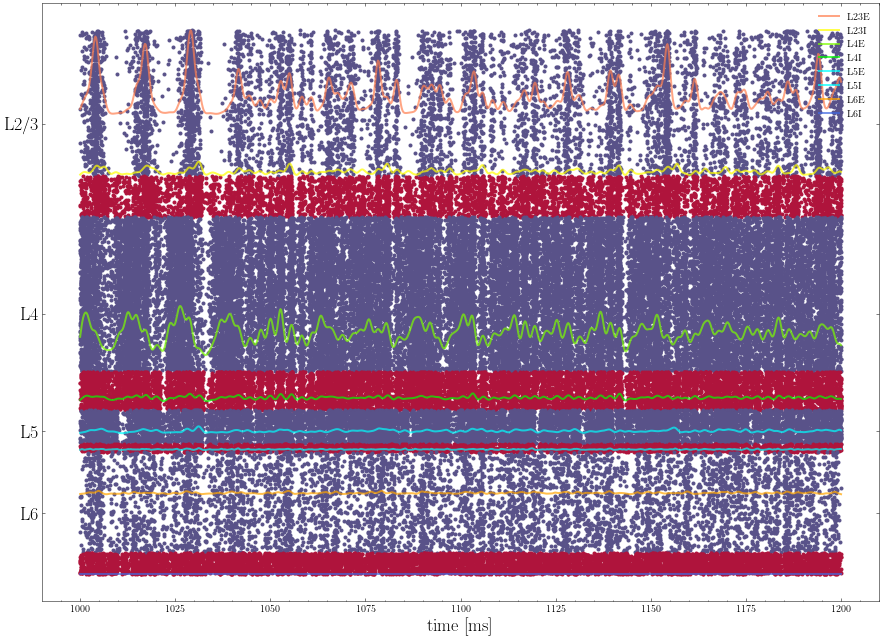

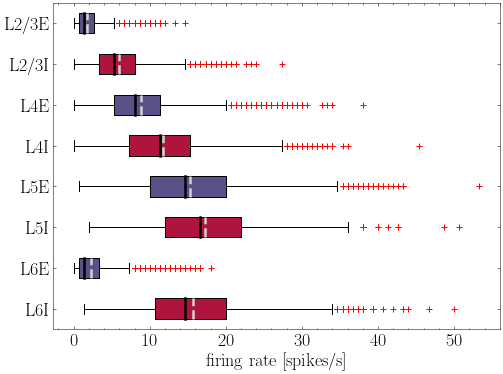

In [7]:
raster_plot_interval = np.array([1000, 1200])
firing_rates_interval = np.array([1000,2500])
pop_activity = net.evaluate(raster_plot_interval, firing_rates_interval,binned=True)
time_evaluate = time.time()